# Neural Network (Classification)

[Theory](#theory)  
[Naive implementation + implicit learned representation](#naive-implementation)  
[Using Keras](#Using-Keras)  
[Using Pytorch](#Using-Pytorch)  
[Using Tensorflow](#Using-Tensorflow)

## Theory

Reference:
- [Brilliant.org on Backpropagation](https://brilliant.org/wiki/backpropagation/)
- [Wikipedia on Backpropagation](https://en.wikipedia.org/wiki/Backpropagation)

let:

- $L$ the number of layers of a neural network
- $r_{k}$ the number of neurons in layer $k$
- $g^k$ the activation function at layer $k$
- $w^{k}_{ij}$ weight that connects neuron $i$ of layer $k-1$ and neuron $j$ of layer $k$
- $z^k_{j} = \sum_i^{r_{k-1}} w^k_{ij}a^{k-1}_i$
- $a^k_j = g^k(z^k_j)$, and $a^0 = x$

With $a^k$, $z^k$ and $W^k$ we denote the 

The feedforward step consist in the computation of all the operation from the first to the last layer, given an input $x$:

$z^1 = W^1 $  

$a^0 = W^1 a^0 $

$a^1 = g^1(z^1) $

$z^2 = W^2 a^1  $

...

$z^L = W^{L-1} a ^{L-1}  $

$a^L = g^L(z^L)  $

The computation of the loss of our model wrt data consist in computing a function $E$ with $a^L$ and the labels/values $y$. E.g. cross-entropy, MSE

The backpropagation method consist in updating the parameters of the model properly. Since we want to minimize the error, we compute the derivative of the error wrt each parameter and then subtract the value to the current estimate of the parameter.

More in detail:

$\begin{equation}
\frac{\partial E}{\partial w^k_{ij}} = 
\frac{\partial E}{\partial a^k_j} \frac{\partial a^k_j}{\partial z^k_j} \frac{\partial z^k_j}{\partial w^k_ij}
\end{equation}
$

Let define:

$\delta^k_j = \frac{\partial E}{\partial a^k_j} \frac{\partial a^k_j}{\partial z^k_j} $

also notice that:

$\frac{\partial z^k_j}{\partial w^k_ij} = a^{k-1}_i$

which allow us to rewrite the previous equation as:

$\frac{\partial E}{\partial w^k_{ij}} = \delta^k_j a^{k-1}_i $

Let's focus on $\delta^k_j$ we distinguish two cases:

- if $k = L$ (that is, the weight is between the last two layers) we have:

$$
\begin{align}
\delta^k_j &= \frac{\partial E}{\partial a^k_j} \frac{\partial a^k_j}{\partial z^k_j} \\
           &= \frac{\partial E}{\partial a^k_j} g^{'k}(z^k_j)\\
\end{align}
$$

the actual derivative depend on the loss function $E$ and the activation function of the last layer $g^k$

- if $k < L$ then we have to compute the total derivative, which can be cleverly refactor for computational efficiency:

$$
\begin{align}
\delta^k_j &= \frac{\partial E}{\partial a^k_j} \frac{\partial a^k_j}{\partial z^k_j} \\
           &= \left  ( \sum_{h}^{r_{k+1}}
                           \frac{\partial E}{\partial a^{k+1}_h} 
                           \frac{\partial a^{k+1}_h}{\partial z^{k+1}_h}
                           \frac{\partial z^{k+1}_h}{\partial a^{k}_j} 
              \right ) 
              \frac{\partial a^k_j}{\partial z^k_j} \\
           &= \left   ( \sum_{h}^{r_{k+1}} \delta^{k+1}_h w^{k+1}_jh
               \right ) g^{'k}(z^k_j)\\
\end{align}
$$




## The data

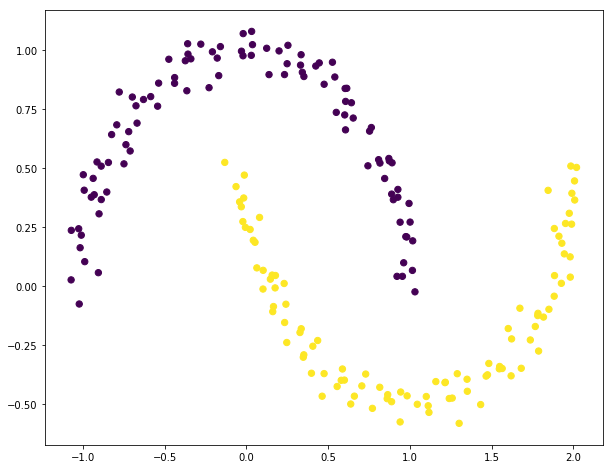

In [1]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
from mlxtend.plotting import plot_decision_regions


# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.05)
plt.scatter(X[:, 0], X[:, 1], s=40, c=y)

# one-hot encoding
y_train = np.zeros((y.size, 2))
y_train[range(len(y)), y] = 1
X_train = X

## Naive Implementation

In [2]:
from sklearn.neural_network._base import softmax

alpha = 0.01
lambda_ = 0.01


def _feed_forward(model, X):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    o = softmax(z2)
    return o, {"z1": z1, "a1": a1, "z2": z2}

    
def predict(model, X):
    output, _ = _feed_forward(model, X)
    return np.argmax(output, axis=1)

def loss_function(model, X, y):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    o, _ = _feed_forward(model, X)
    
    reg_term = lambda_/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2))) 
    data_loss = np.sum(-np.log(o[range(len(X)), y]))
    data_loss += reg_term
    data_loss = data_loss / X.shape[0]
    
    return data_loss
    

def train_model(X, y, hidden_size, epochs=10000):
    input_size = X.shape[1]
    output_size = 2
    
    # Initialize the parameters to random values. We need to learn these.
    # weight initialization: 
    #    - https://medium.com/usf-msds/deep-learning-best-practices-1-weight-initialization-14e5c0295b94
    np.random.seed(0)
    W1 = np.random.randn(input_size, hidden_size) / np.sqrt(input_size)
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) / np.sqrt(hidden_size)
    b2 = np.zeros((1, output_size))
    
    model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

    for i in range(0, epochs):
        o, cache = _feed_forward(model, X)
        
        # https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/
        # delta3 = o - y
        delta3 = o
        delta3[range(len(X)), y] -= 1
        delta2 = delta3.dot(W2.T) * (1 - np.power(cache["a1"], 2))
                
        dW2 = cache["a1"].T.dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        dW2 += lambda_ * W2
        dW1 += lambda_ * W1
        
        W2 += -alpha * dW2
        W1 += -alpha * dW1
        b2 += -alpha * db2
        b1 += -alpha * db1
        
        model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        if i % 1000 == 0:
            print("Epoch: %04d" % i, loss_function(model, X, y))
            # print(b2, b1)
        
    return model


Epoch: 0000 0.41886789635417593
Epoch: 1000 0.004859957006923416
Epoch: 2000 0.004636019624475354
Epoch: 3000 0.004600056169688691
Epoch: 4000 0.004587661735283828
Epoch: 5000 0.004581521801568179
Epoch: 6000 0.004577938361415669
Epoch: 7000 0.004575660955264387
Epoch: 8000 0.004574131562016374
Epoch: 9000 0.004573061985719588


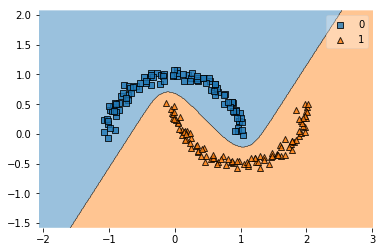

In [3]:
hidden_size = 3
model = train_model(X, y, hidden_size)

# a dummy class to "do the trick" with 'plot_decision_regions'
class Classifier():

    def predict(self, X):
        return predict(model, X)
    

plot_decision_regions(X, y, clf=Classifier())

### Implicit learned representation
As you might see, data become linearly separable

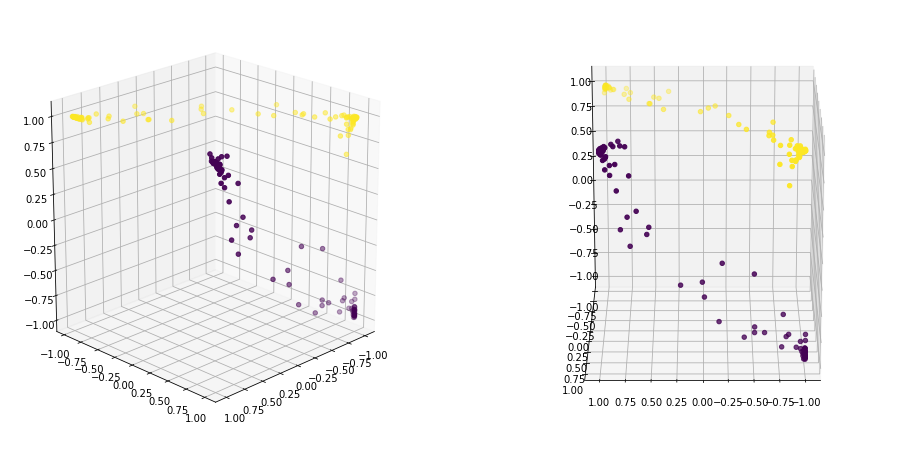

In [4]:
W1, b1 = model["W1"], model["b1"]
Z = np.tanh(X.dot(W1) + b1)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.view_init(20, 45)
ax1.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=y)

ax2.view_init(20, 90)
ax2.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=y)


## Using Keras

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 3)                 9         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 8         
_________________________________________________________________
softmax_2 (Softmax)          (None, 2)                 0         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________
last loss:  0.02298990957438946


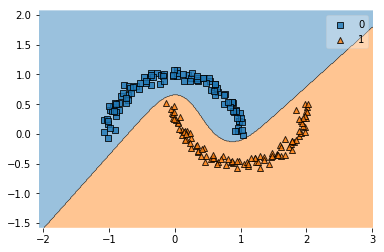

In [6]:
import keras
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

from keras import optimizers
from keras.layers import Dense, Softmax


input_size = 2
hidden_size = 3
output_size = 2
learning_rate = 0.05

model = keras.Sequential()
model.add(Dense(hidden_size, input_dim=input_size, use_bias=True, 
                kernel_initializer=keras.initializers.glorot_normal(seed=None),
                bias_initializer="zeros", activation="tanh"))
model.add(Dense(output_size, use_bias=True, 
                kernel_initializer=keras.initializers.glorot_normal(seed=None), 
                bias_initializer="zeros"))
model.add(Softmax(output_size))


sgd = optimizers.SGD(lr=learning_rate)
model.compile(sgd, loss="binary_crossentropy")
model.summary()

history = model.fit(X, y_train, epochs=2000, verbose=0)
print("last loss: ", history.history["loss"][-1])

class Wrapper():
    def predict(self, X):
        y_pred = model.predict(X)
        y = np.argmax(y_pred, axis=1)
        return y
    
plot_decision_regions(X, y, clf=Wrapper())

## Using Pytorch


Epoch: 00000 0.8043137192726135
Epoch: 01000 0.424957275390625
Epoch: 02000 0.42416152358055115
Epoch: 03000 0.4234332740306854
Epoch: 04000 0.42264997959136963


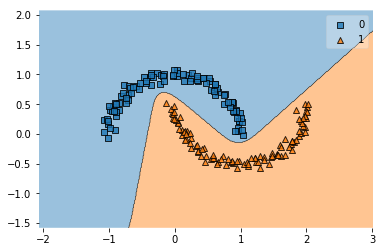

In [8]:
import torch

device = torch.device('cpu')
# device = torch.device('cuda')

input_size = 2
hidden_size = 3
output_size = 2
learning_rate = 0.01
epochs = 5000

model = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Tanh(),
    torch.nn.Linear(hidden_size, output_size),
    torch.nn.Softmax(1)
)

def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


model.apply(init_weights)


def train_model(model, X, y, epochs=epochs):
    # Create Tensors to hold inputs and outputs
    X_torch = torch.FloatTensor(X, device=device)
    y_torch = torch.LongTensor(y, device=device)
    
    loss_f = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for i in range(epochs):
        
        y_pred = model(X_torch)
        
        current_loss = loss_f(y_pred, y_torch)
        # zero the gradients
        optimizer.zero_grad()
        # compute gradient of the loss wrt weights
        current_loss.backward()
        # update parameters
        optimizer.step()
        
        if i % 1000 == 0:
            print("Epoch: %05d" % i, current_loss.item())
            
    return model


model = train_model(model, X_train, y)

class Wrapper:
    
    def __init__(self, pytorch_model):
        self.model = pytorch_model
    
    def predict(self, X):
        X_torch = torch.FloatTensor(X, device=device)
        y = self.model(X_torch)
        y_pred = np.argmax(y.detach().numpy(), axis=1)
        return y_pred
    

plot_decision_regions(X_train, y, clf=Wrapper(model))

Epoch: 00000 0.6836811304092407
Epoch: 01000 0.42462021112442017
Epoch: 02000 0.42405715584754944
Epoch: 03000 0.3138568699359894
Epoch: 04000 0.31346791982650757


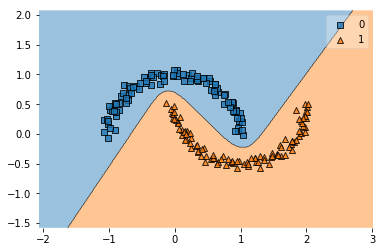

In [9]:
# Module version

class MyNet(torch.nn.Module):
    
    def __init__(self):    
        super().__init__()
        self.input_layer = torch.nn.Linear(input_size, hidden_size)
        self.hidden_layer = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        
        hidden = torch.nn.Tanh()(self.input_layer(x))
        output = torch.nn.Softmax(1)(self.hidden_layer(hidden))
        return output
        
model = MyNet()
model = train_model(model, X_train, y)

plot_decision_regions(X_train, y, clf=Wrapper(model))

## Using Tensorflow

loss at 0:  1.5366687
loss at 1000:  0.03384776
loss at 2000:  0.033642557
loss at 3000:  0.033633534
loss at 4000:  0.03363346
final loss:  0.03363346


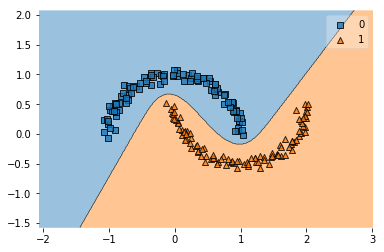

In [12]:
import tensorflow as tf

learning_rate = 0.05
lambda_ = 0.001

X_train = X
# one-hot encoding
y_train = np.zeros((y.shape[0], 2))
y_train[np.arange(y.shape[0]), y] = 1

input_size = 2
hidden_size = 3
output_size = 2
epochs = 5000

Xtf = tf.placeholder(tf.float32, [None, input_size])
Ytf = tf.placeholder(tf.float32)

W1 = tf.Variable(tf.random_normal((input_size, hidden_size)))
W2 = tf.Variable(tf.random_normal((hidden_size, output_size)))
b1 = tf.Variable(tf.random_normal((hidden_size, )))
b2 = tf.Variable(tf.random_normal((output_size, )))

l_input = tf.add(tf.matmul(Xtf, W1), b1)
l_input = tf.nn.tanh(l_input)
l_output = tf.matmul(l_input, W2) + b2

regularization_term = lambda_/2 * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(b1) + tf.nn.l2_loss(b2))
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=l_output, labels=Ytf))
cost = tf.add(cost, regularization_term)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    for i in range(epochs):
        sess.run(optimizer, feed_dict={Xtf: X_train, Ytf: y_train})
        current_loss = sess.run(cost, {Xtf: X_train, Ytf: y_train})
        
        if i % 1000 == 0:
            print("loss at %d: " % i, current_loss)
        
    print("final loss: ", sess.run(cost, {Xtf: X_train, Ytf: y_train}))
    
    class Wrapper:
        
        def predict(self, X):
            output = sess.run(l_output, feed_dict={Xtf: X})
            return np.argmax(output, axis=1)
        
    plot_decision_regions(X_train, y, clf=Wrapper())